In [162]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import torch
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import csv
import random
import os
import codecs
from io import open
import itertools
import math


USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print(device)

cuda


In [0]:
Start_token = 0 #**
End_token = 1 #EOS
Padding_token = 2 #//

class Voc:
    def __init__(self):
        self.wordindex = {}
        self.wordcount = {}
        self.indexword = {0: "**", 1: "EOS", 2:"//"}
        self.num_words = 3  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.wordindex:
            self.wordindex[word] = self.num_words
            self.wordcount[word] = 1
            self.indexword[self.num_words] = word
            self.num_words += 1
        else:
            self.wordcount[word] += 1

In [0]:
# http://stackoverflow.com/a/518232/2809427
import unicodedata
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s

In [165]:
print("Reading lines...")
lines = open('formatted_movie_lines.txt', 'r', encoding='utf-8')
lines = lines.read().strip().split('\n')
print("total lines are " + str(len(lines)))

Reading lines...
total lines are 327156


In [166]:
import re
print("Preprocessing lines...")
pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

Preprocessing lines...


In [0]:
newpairs = []
for pair in pairs:
    newpair = []
    index = 0
    while index in range(len(pair)):
        if(pair[index] != ''):
            newpair.append(pair[index])
        index +=1
    newpairs.append(newpair)

In [0]:
vocab = Voc()

In [169]:
threshold = 12
line_pairs = []
for pair in pairs:
    check1 = False
    check2 = False
    #print(pair)
    if len(pair) != 2:
        continue
    else:
        if len(pair[0].split(' ')) < threshold:
            check1 = True
        if len(pair[1].split(' ')) < threshold:
            check2 = True
        if check1 and check2:
            line_pairs.append(pair)
print("Line Pairs are " + str(len(line_pairs)))

Line Pairs are 101411


In [170]:
for line in line_pairs:
    vocab.addSentence(line[0])
    vocab.addSentence(line[1])
print("Total number of words:", vocab.num_words)

Total number of words: 23356


In [171]:
for line in lines[:10]:
    print(line)
pairs = line_pairs

Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.	Well, I thought we'd start with pronunciation, if that's okay with you.
Well, I thought we'd start with pronunciation, if that's okay with you.	Not the hacking and gagging and spitting part.  Please.
Not the hacking and gagging and spitting part.  Please.	Okay... then how 'bout we try out some French cuisine.  Saturday?  Night?
You're asking me out.  That's so cute. What's your name again?	Forget it.
No, no, it's my fault -- we didn't have a proper introduction ---	Cameron.
Cameron.	The thing is, Cameron -- I'm at the mercy of a particularly hideous breed of loser.  My sister.  I can't date until she does.
The thing is, Cameron -- I'm at the mercy of a particularly hideous breed of loser.  My sister.  I can't date until she does.	Seems like she could get a date easy enough...
Why?	Unsolved mystery.  She used to be really popular when she started high sch

In [172]:
keep_pairs = []
for pair in pairs:
    input_sentence = pair[0]
    output_sentence = pair[1]
    keep_input = True
    keep_output = True
    # Check input sentence
    for word in input_sentence.split(' '):
        if word not in vocab.wordindex:
            keep_input = False
            break
        # Check output sentence
    for word in output_sentence.split(' '):
        if word not in vocab.wordindex:
            keep_output = False
            break

    # Only keep pairs that do not contain trimmed word(s) in their input or output sentence
    if keep_input and keep_output:
        keep_pairs.append(pair)

print("Trimmed from {} pairs to {}, {:.4f} of total".format(len(pairs), len(keep_pairs), len(keep_pairs) / len(pairs)))
pairs =  keep_pairs

Trimmed from 101411 pairs to 101411, 1.0000 of total


In [0]:
def indexesFromSentence(voc, sentence):
    return [voc.wordindex[word] for word in sentence.split(' ')] + [End_token]


def zeroPadding(l, fillvalue=Padding_token):
    return list(itertools.zip_longest(*l, fillvalue=fillvalue))

def binaryMatrix(l, value=Padding_token):
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token == Padding_token:
                m[i].append(0)
            else:
                m[i].append(1)
    return m


def inputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    padVar = torch.LongTensor(padList)
    return padVar, lengths


def outputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    max_target_len = max([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    mask = binaryMatrix(padList)
    mask = torch.ByteTensor(mask)
    padVar = torch.LongTensor(padList)
    return padVar, mask, max_target_len


def batch2TrainData(voc, pair_batch):
    pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)
    input_batch, output_batch = [], []
    for pair in pair_batch:
        input_batch.append(pair[0])
        output_batch.append(pair[1])
    inp, lengths = inputVar(input_batch, voc)
    output, mask, max_target_len = outputVar(output_batch, voc)
    return inp, lengths, output, mask, max_target_len

def maskNLLLoss(inp, target, mask):
    nTotal = mask.sum()
    crossEntropy = -torch.log(torch.gather(inp, 1, target.view(-1, 1)).squeeze(1))
    loss = crossEntropy.masked_select(mask).mean()
    loss = loss.to(device)
    return loss, nTotal.item()

In [174]:
MAX_LENGTH = 9
small_batch_size = 5
batches = batch2TrainData(vocab, [random.choice(pairs) for _ in range(small_batch_size)])
input_variable, lengths, target_variable, mask, max_target_len = batches

print("input_variable:", input_variable)
print("lengths:", lengths)
print("target_variable:", target_variable)
print("mask:", mask)
print("max_target_len:", max_target_len)

input_variable: tensor([[ 127,   78,   65,   15, 2278],
        [ 128,   22,    7,   16,   48],
        [ 112,   21,    7, 1417, 1124],
        [ 903,  669,    7,   21,   78],
        [  31,   15,  114,   48,  101],
        [ 102,  145,  156,  572,  719],
        [ 916,  766,  537,  769,  110],
        [ 155,   31,  469,    7,    7],
        [ 102,   14,   14,    1,    1],
        [   1,    1,    1,    2,    2]])
lengths: tensor([10, 10, 10,  9,  9])
target_variable: tensor([[   66,    19,    78,   114,   241],
        [   15, 17598,    75,   256,    48],
        [  127,    87,   101,    48,    46],
        [  128,  1322,   328,    57,     7],
        [  102, 17599,    40,  1417,     1],
        [    1,     7,    14,    14,     2],
        [    2,     1,     7,     1,     2],
        [    2,     2,     7,     2,     2],
        [    2,     2,     7,     2,     2],
        [    2,     2,     1,     2,     2]])
mask: tensor([[1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 

In [0]:
#https://jeddy92.github.io/JEddy92.github.io/ts_seq2seq_intro/
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding

        # Initialize GRU; the input_size and hidden_size params are both set to 'hidden_size'
        #   because our input size is a word embedding with number of features == hidden_size
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers,
                          dropout=(0 if n_layers == 1 else dropout), bidirectional=True)

    def forward(self, input_seq, input_lengths, hidden=None):
        # Convert word indexes to embeddings
        embedded = self.embedding(input_seq)
        # Pack padded batch of sequences for RNN module
        packed = nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        # Forward pass through GRU
        outputs, hidden = self.gru(packed, hidden)
        # Unpack padding
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
        # Sum bidirectional GRU outputs
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
        # Return output and final hidden state
        return outputs, hidden

In [0]:
# Luong attention layer
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)
        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(hidden_size))

    def dot_score(self, hidden, encoder_output):
        return torch.sum(hidden * encoder_output, dim=2)

    def general_score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)
        return torch.sum(hidden * energy, dim=2)

    def concat_score(self, hidden, encoder_output):
        energy = self.attn(torch.cat((hidden.expand(encoder_output.size(0), -1, -1), encoder_output), 2)).tanh()
        return torch.sum(self.v * energy, dim=2)

    def forward(self, hidden, encoder_outputs):
        # Calculate the attention weights (energies) based on the given method
        if self.method == 'general':
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == 'concat':
            attn_energies = self.concat_score(hidden, encoder_outputs)
        elif self.method == 'dot':
            attn_energies = self.dot_score(hidden, encoder_outputs)

        # Transpose max_length and batch_size dimensions
        attn_energies = attn_energies.t()

        # Return the softmax normalized probability scores (with added dimension)
        return F.softmax(attn_energies, dim=1).unsqueeze(1)

In [0]:
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, embedding, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        # Keep for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        # Define layers
        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

        self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_step, last_hidden, encoder_outputs):
        # Note: we run this one step (word) at a time
        # Get embedding of current input word
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)
        # Forward through unidirectional GRU
        rnn_output, hidden = self.gru(embedded, last_hidden)
        # Calculate attention weights from the current GRU output
        attn_weights = self.attn(rnn_output, encoder_outputs)
        # Multiply attention weights to encoder outputs to get new "weighted sum" context vector
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        # Concatenate weighted context vector and GRU output using Luong eq. 5
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))
        # Predict next word using Luong eq. 6
        output = self.out(concat_output)
        output = F.softmax(output, dim=1)
        # Return output and final hidden state
        return output, hidden

In [0]:
def train(input_variable, lengths, target_variable, mask, max_target_len, encoder, decoder, embedding,
          encoder_optimizer, decoder_optimizer, batch_size, clip, max_length=MAX_LENGTH):

    # Zero gradients
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # Set device options
    input_variable = input_variable.to(device)
    lengths = lengths.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)

    # Initialize variables
    loss = 0
    print_losses = []
    n_totals = 0

    # Forward pass through encoder
    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)

    # Create initial decoder input (start with SOS tokens for each sentence)
    decoder_input = torch.LongTensor([[Start_token for _ in range(batch_size)]])
    decoder_input = decoder_input.to(device)

    # Set initial decoder hidden state to the encoder's final hidden state
    decoder_hidden = encoder_hidden[:decoder.n_layers]

    # Determine if we are using teacher forcing this iteration
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    # Forward batch of sequences through decoder one time step at a time
    if use_teacher_forcing:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # Teacher forcing: next input is current target
            decoder_input = target_variable[t].view(1, -1)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal
    else:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # No teacher forcing: next input is decoder's own current output
            _, topi = decoder_output.topk(1)
            decoder_input = torch.LongTensor([[topi[i][0] for i in range(batch_size)]])
            decoder_input = decoder_input.to(device)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal

    # Perform backpropatation
    loss.backward()

    # Clip gradients: gradients are modified in place
    _ = nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    # Adjust model weights
    encoder_optimizer.step()
    decoder_optimizer.step()

    return sum(print_losses) / n_totals

In [0]:
avg_losses = []
def trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer, embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size, print_every, save_every, clip, corpus_name, loadFilename):

    # Load batches for each iteration
    training_batches = [batch2TrainData(voc, [random.choice(pairs) for _ in range(batch_size)])
                      for _ in range(n_iteration)]

    # Initializations
    print('Initializing ...')
    start_iteration = 1
    print_loss = 0
    if loadFilename:
        start_iteration = checkpoint['iteration'] + 1

    # Training loop
    print("Training...")
    for iteration in range(start_iteration, n_iteration + 1):
        training_batch = training_batches[iteration - 1]
        # Extract fields from batch
        input_variable, lengths, target_variable, mask, max_target_len = training_batch

        # Run a training iteration with batch
        loss = train(input_variable, lengths, target_variable, mask, max_target_len, encoder,
                     decoder, embedding, encoder_optimizer, decoder_optimizer, batch_size, clip)
        print_loss += loss

        # Print progress
        if iteration % print_every == 0:
            print_loss_avg = print_loss / print_every
            avg_losses.append(print_loss_avg)
            print("Iteration: {}; Percent complete: {:.1f}%; Average loss: {:.4f}".format(iteration, iteration / n_iteration * 100, print_loss_avg))
            print_loss = 0

        # Save checkpoint
        if (iteration % save_every == 0):
            directory = os.path.join(save_dir, model_name, corpus_name, '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size))
            if not os.path.exists(directory):
                os.makedirs(directory)
            torch.save({
                'iteration': iteration,
                'en': encoder.state_dict(),
                'de': decoder.state_dict(),
                'en_opt': encoder_optimizer.state_dict(),
                'de_opt': decoder_optimizer.state_dict(),
                'loss': loss,
                'voc_dict': voc.__dict__,
                'embedding': embedding.state_dict()
            }, os.path.join(directory, '{}_{}.tar'.format(iteration, 'checkpoint')))

In [180]:
# Configure models
model_name = 'cb_model'
attn_model = 'dot'
#attn_model = 'general'
#attn_model = 'concat'
hidden_size = 500
encoder_n_layers = 2
decoder_n_layers = 2
dropout = 0.1
batch_size = 64

# Set checkpoint to load from; set to None if starting from scratch
loadFilename = None
checkpoint_iter = 4000
#loadFilename = os.path.join(save_dir, model_name, corpus_name,
#                            '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size),
#                            '{}_checkpoint.tar'.format(checkpoint_iter))


# Load model if a loadFilename is provided
if loadFilename:
    # If loading on same machine the model was trained on
    checkpoint = torch.load(loadFilename)
    # If loading a model trained on GPU to CPU
    #checkpoint = torch.load(loadFilename, map_location=torch.device('cpu'))
    encoder_sd = checkpoint['en']
    decoder_sd = checkpoint['de']
    encoder_optimizer_sd = checkpoint['en_opt']
    decoder_optimizer_sd = checkpoint['de_opt']
    embedding_sd = checkpoint['embedding']
    voc.__dict__ = checkpoint['voc_dict']


print('Building encoder and decoder ...')
# Initialize word embeddings
embedding = nn.Embedding(vocab.num_words, hidden_size)
if loadFilename:
    embedding.load_state_dict(embedding_sd)
# Initialize encoder & decoder models
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, vocab.num_words, decoder_n_layers, dropout)
if loadFilename:
    encoder.load_state_dict(encoder_sd)
    decoder.load_state_dict(decoder_sd)
# Use appropriate device
encoder = encoder.to(device)
decoder = decoder.to(device)
print('Models built and ready to go!')

Building encoder and decoder ...
Models built and ready to go!


In [181]:
# Configure training/optimization
clip = 50.0
teacher_forcing_ratio = 1.0
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_iteration = 10000
print_every = 50
save_every = 500
save_dir = os.path.join("data", "save")
corpus_name = "Testing"
# Ensure dropout layers are in train mode
encoder.train()
decoder.train()

# Initialize optimizers
print('Building optimizers ...')
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
if loadFilename:
    encoder_optimizer.load_state_dict(encoder_optimizer_sd)
    decoder_optimizer.load_state_dict(decoder_optimizer_sd)

# Run training iterations
print("Starting Training!")
trainIters(model_name, vocab, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer,
           embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size,
           print_every, save_every, clip, corpus_name, loadFilename)

Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 50; Percent complete: 0.5%; Average loss: 6.1814
Iteration: 100; Percent complete: 1.0%; Average loss: 5.0564
Iteration: 150; Percent complete: 1.5%; Average loss: 4.8466
Iteration: 200; Percent complete: 2.0%; Average loss: 4.6639
Iteration: 250; Percent complete: 2.5%; Average loss: 4.5054
Iteration: 300; Percent complete: 3.0%; Average loss: 4.4073
Iteration: 350; Percent complete: 3.5%; Average loss: 4.2641
Iteration: 400; Percent complete: 4.0%; Average loss: 4.2160
Iteration: 450; Percent complete: 4.5%; Average loss: 4.1781
Iteration: 500; Percent complete: 5.0%; Average loss: 4.1302
Iteration: 550; Percent complete: 5.5%; Average loss: 4.1004
Iteration: 600; Percent complete: 6.0%; Average loss: 4.0214
Iteration: 650; Percent complete: 6.5%; Average loss: 3.9944
Iteration: 700; Percent complete: 7.0%; Average loss: 4.0026
Iteration: 750; Percent complete: 7.5%; Average loss: 3.9119
Iteration: 800

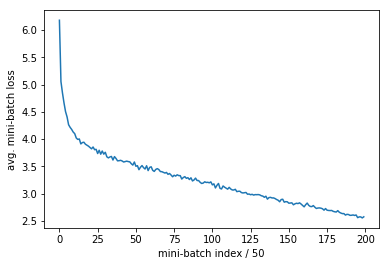

In [182]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_every))
plt.ylabel('avg. mini-batch loss')
plt.show()

In [0]:
class GreedySearchDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(GreedySearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq, input_length, max_length):
        # Forward input through encoder model
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        # Prepare encoder's final hidden layer to be first hidden input to the decoder
        decoder_hidden = encoder_hidden[:decoder.n_layers]
        # Initialize decoder input with SOS_token
        decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * Start_token
        # Initialize tensors to append decoded words to
        all_tokens = torch.zeros([0], device=device, dtype=torch.long)
        all_scores = torch.zeros([0], device=device)
        # Iteratively decode one word token at a time
        for _ in range(max_length):
            # Forward pass through decoder
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
            # Obtain most likely word token and its softmax score
            decoder_scores, decoder_input = torch.max(decoder_output, dim=1)
            # Record token and score
            all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
            all_scores = torch.cat((all_scores, decoder_scores), dim=0)
            # Prepare current token to be next decoder input (add a dimension)
            decoder_input = torch.unsqueeze(decoder_input, 0)
        # Return collections of word tokens and scores
        return all_tokens, all_scores

In [0]:
def evaluate(encoder, decoder, searcher, voc, sentence, max_length=MAX_LENGTH):
    ### Format input sentence as a batch
    # words -> indexes
    indexes_batch = [indexesFromSentence(voc, sentence)]
    # Create lengths tensor
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    # Transpose dimensions of batch to match models' expectations
    input_batch = torch.LongTensor(indexes_batch).transpose(0, 1)
    # Use appropriate device
    input_batch = input_batch.to(device)
    lengths = lengths.to(device)
    # Decode sentence with searcher
    tokens, scores = searcher(input_batch, lengths, max_length)
    # indexes -> words
    decoded_words = [voc.indexword[token.item()] for token in tokens]
    return decoded_words

In [0]:
def evaluateInput(encoder, decoder, searcher, voc):
    input_sentence = ''
    while(1):
        try:
            # Get input sentence
            input_sentence = input('> ')
            # Check if it is quit case
            if input_sentence == 'q' or input_sentence == 'quit': break
            # Normalize sentence
            input_sentence = normalizeString(input_sentence)
            # Evaluate sentence
            output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
            # Format and print response sentence
            output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
            print('Bot:', ' '.join(output_words))

        except KeyError:
            print("Error: Encountered unknown word.")

In [0]:
encoder.eval()
decoder.eval()
searcher = GreedySearchDecoder(encoder, decoder)

In [187]:
evaluateInput(encoder, decoder, searcher, vocab)

> hi
Bot: hi . it . it .
> how are you
Bot: i m fine . my feet !
> i love you
Bot: i love you . it . it
> oh no
Bot: no . it . it .
> hahaha
Bot: you re not going to be a minute .
> quit


In [188]:
import pandas as pd
print("Loading the first file")
df = pd.read_csv('text_emotion.csv', encoding='latin_1')
df.dropna()
df.head()
df_list = [df.columns.values.astype('U').tolist()] + df.values.tolist()
df_sentence = [df_list[x+1][1] for x in range(len(df_list)-1)]
emotion = [df_list[x+1][0] for x in range(len(df_list)-1)]
mylist = list(set(emotion))
print("Emotions in the first file: ")
print(mylist)
import numpy as np
print("Processing the first file")
valence_3 = np.zeros(len(emotion))
arousal_3 = np.zeros(len(emotion))

Loading the first file
Emotions in the first file: 
['relief', 'surprise', 'anger', 'fun', 'enthusiasm', 'boredom', 'neutral', 'love', 'worry', 'sadness', 'happiness', 'empty', 'hate']
Processing the first file


In [0]:
one_one = []
zero_zero = []
zero_one = []
one_zero = []
i = 0
j = 0
while i < int(len(emotion)):
    if(emotion[i] == 'fun' or emotion[i] == 'happiness' or emotion[i] == 'enthusiasm' or emotion[i] == 'love'):
        valence_3[j] = 1
        arousal_3[j] = 1
        one_one.append(df_sentence[i])
        j+=1
    i += 1
i = 0
while i < int(len(emotion)):
    if(emotion[i] == 'sad' or emotion[i] == 'boredom' or emotion[i] == 'worry'):
        valence_3[j] = 0
        arousal_3[j] = 0
        zero_zero.append(df_sentence[i])
        j+=1
    i += 1
i = 0
while i < int(len(emotion)):
    if(emotion[i] == 'anger' or emotion[i] == 'hate'):
        valence_3[j] = 0
        arousal_3[j] = 1
        zero_one.append(df_sentence[i])
        j+=1
    i += 1
i = 0
while i < int(len(emotion)):
    if(emotion[i] == 'neural' or emotion[i] == 'relief'):
        valence_3[j] = 1
        arousal_3[j] = 0
        one_zero.append(df_sentence[i])
        j+=1
    i+=1
valence3 = np.zeros(j)
arousal3 = np.zeros(j)
for i in range(j):
    valence3[i] = valence_3[i]
    arousal3[i] = arousal_3[i]

In [190]:
df_sentence = one_one + zero_zero + zero_one + one_zero
print("Done processing the first file")
print("The total dataset of the first file is " + str(len(df_sentence)))
print("\nStart loading the second file")

emo = pd.read_csv('emo.csv', encoding='latin_1')
emo.dropna()
emo_list = [emo.columns.values.astype('U').tolist()] + emo.values.tolist()
valence_1 = np.zeros(len(emo_list)-1)
arousal_1 = np.zeros(len(emo_list)-1)
print("Processing the second file")
i = 1
while i < int(len(emo_list)):
    if emo_list[i][1] >= 3:
        valence_1[i-1] = 1 #for positive valence
    else:
        valence_1[i-1] = 0 #for negative valence
    if emo_list[i][2] >= 3:
        arousal_1[i-1] = 1 #for positive arousal
    else:
        arousal_1[i-1] = 0 #for negative arousal
    i+=1
print("Done processing the second file")
#print(valence_1.shape)
#print(valence_2.shape)
emo_sentence = [emo_list[x+1][0] for x in range(len(emo_list)-1)]
#fb_sentence = [fb_list[x+1][0] for x in range(len(fb_list)-1)]
#sentence = emo_sentence + fb_sentence + df_sentence
sentence = emo_sentence + df_sentence
valence_np = np.hstack((valence_1, valence3)) #, valence_2
arousal_np = np.hstack((arousal_1, arousal3)) #, arousal_2
valence = valence_np.tolist()
arousal = arousal_np.tolist()
from sklearn.model_selection import train_test_split
#S_train = [sentence[i].value().astype(U) for i in range(len(sentence))]
S_train = sentence
v_train = valence
a_train = arousal
print("The total length of the dataset is " + str(len(S_train)))

Done processing the first file
The total dataset of the first file is 23183

Start loading the second file
Processing the second file
Done processing the second file
The total length of the dataset is 33274


In [0]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
middle_words = ['and','a','the','am','it','me','with','in','on','by','near','this','that','an','there','here','those','ourselves', 'hers', 'between', 'yourself', 'but', 'again', 'there', 'about', 'once',
                'during', 'out', 'very', 'having', 'with', 'they', 'own', 'an', 'be', 'some', 'for', 'do', 'its', 'yours', 'such', 'into',
                'of', 'most', 'itself', 'other', 'off', 'is', 's', 'am', 'or', 'who', 'as', 'from', 'him', 'each', 'the', 'themselves',
                'until', 'below', 'are', 'we', 'these', 'your', 'his', 'through', 'don', 'nor', 'me', 'were', 'her', 'more',
                'himself', 'this', 'down', 'should', 'our', 'their', 'while', 'above', 'both', 'up', 'to', 'ours', 'had', 'she',
                'all', 'when', 'at', 'any', 'before', 'them', 'same', 'and', 'been', 'have', 'in', 'will', 'on', 'does', 'yourselves',
                'then', 'that', 'because', 'what', 'over', 'why', 'so', 'can', 'did', 'now', 'under', 'he', 'you', 'herself', 'has', 'just', 'where', 'myself', 'which', 'those', 'i',
                'after', 'few', 'whom', 't', 'being', 'if', 'theirs', 'my', 'against', 'a', 'by', 'doing', 'it', 'how', 'further', 'was', 'here', 'than']
middle_words = set(dict.fromkeys([stemmer.stem(word) for word in middle_words]))
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')

def tokenize(sentence):
    tokens = tokenizer.tokenize(sentence)
    for w in middle_words:
        while w in tokens:
            tokens.remove(w)
    toReturn = [stemmer.stem(item.lower()) for item in tokens]
    return toReturn

In [0]:
def tokenize(sentence):
    tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
    stemmer = SnowballStemmer("english")
    middle_words = ['and','a','the','am','it','me','with','in','on','by','near','this','that','an','there','here','those',
                'ourselves', 'hers', 'between', 'yourself', 'but', 'again', 'there', 'about', 'once','during', 'out', 'very',
                'having', 'with', 'they', 'own', 'an', 'be', 'some', 'for', 'do', 'its', 'yours', 'such', 'into', 'of', 'most',
                'itself', 'other', 'off', 'is', 's', 'am', 'or', 'who', 'as', 'from', 'him', 'each', 'the', 'themselves',
                'until', 'below', 'are', 'we', 'these', 'your', 'his', 'through', 'don', 'nor', 'me', 'were', 'her', 'more',
                'himself', 'this', 'down', 'should', 'our', 'their', 'while', 'above', 'both', 'up', 'to', 'ours', 'had', 'she',
                'all', 'when', 'at', 'any', 'before', 'them', 'same', 'and', 'been', 'have', 'in', 'will', 'on', 'does',
                'yourselves', 'then', 'that', 'because', 'what', 'over', 'so', 'can', 'did', 'now', 'under', 'he', 'you',
                'herself', 'has', 'just', 'where', 'myself', 'which', 'those', 'i', 'after', 'few', 'whom', 't', 'being', 'if',
                'theirs', 'my', 'against', 'a', 'by', 'doing', 'it', 'how', 'further', 'was', 'here', 'than', 's', 't', 'can', 'will',
                'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren']
    middle_words = set(dict.fromkeys([stemmer.stem(word) for word in middle_words]))
    tokens = tokenizer.tokenize(sentence)
    for w in middle_words:
        while w in tokens:
            tokens.remove(w)
    toReturn = [stemmer.stem(item.lower()) for item in tokens]
    return toReturn

In [193]:
print("\n Preprocessing the data...")
from sklearn.feature_extraction.text import TfidfVectorizer
count_vect = TfidfVectorizer(ngram_range=(1,3), tokenizer=tokenize)
trainX = count_vect.fit_transform(S_train)
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(v_train)
target_labels = le.classes_
trainy = le.transform(v_train)
print("\n Define tuning functions...")


 Preprocessing the data...

 Define tuning functions...


In [194]:
def train_classifier_valence(X, y):
    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import GridSearchCV
    '''param_grid = {'C': [1, 5, 10, 25]}
        print("grid search start")
        grid = GridSearchCV(LogisticRegression(random_state=0, solver='lbfgs', class_weight='balanced', max_iter=10000),
        param_grid, cv=5)
        print("done grid search")
        grid.fit(X, y)
        print("Best cross-validation score: {:.2f}".format(grid.best_score_))
        print("Best parameters: ", grid.best_params_)
        print("Best estimator: ", grid.best_estimator_)'''
    cls = LogisticRegression(C=5, class_weight='balanced', dual=False,
                             fit_intercept=True, intercept_scaling=1, max_iter=10000,
                             multi_class='warn', n_jobs=None, penalty='l2', random_state=0,
                             solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)#grid.best_estimator_
    cls.fit(X, y)
    print("Parameters: ", cls.get_params)
    print("Score: ", str(cls.score(X,y)))
    return cls

def train_classifier_arousal(X, y):
    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import GridSearchCV
    '''param_grid = {'C': [1, 5, 10, 25]}
        print("grid search start")
        grid = GridSearchCV(LogisticRegression(random_state=0, solver='lbfgs', class_weight='balanced', max_iter=10000),
        param_grid, cv=5)
        print("done grid search")
        grid.fit(X, y)
        print("Best cross-validation score: {:.2f}".format(grid.best_score_))
        print("Best parameters: ", grid.best_params_)
        print("Best estimator: ", grid.best_estimator_)'''
    cls = LogisticRegression(C=10, class_weight='balanced', dual=False,
                             fit_intercept=True, intercept_scaling=1, max_iter=10000,
                             multi_class='warn', n_jobs=None, penalty='l2', random_state=0,
                             solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)#grid.best_estimator_
    cls.fit(X, y)
    print("Parameters: ", cls.get_params)
    print("Score: ", str(cls.score(X,y)))
    return cls

print("Done preprocessing\n")

Done preprocessing



In [195]:
print("Start Training valence classifier")
cls_valence = train_classifier_valence(trainX, trainy)
#cls_valence = train_bagging(trainX, trainy)
#cls_valence = train_random(trainX, trainy)
le_a = preprocessing.LabelEncoder()
le_a.fit(a_train)
target_labels_a = le_a.classes_
trainy = le_a.transform(a_train)
print("Done training valence\n")
print("Start Training arousal classifier")
le_a = preprocessing.LabelEncoder()
cls_arousal = train_classifier_arousal(trainX, trainy)
#cls_arousal = train_bagging(trainX, trainy)
#cls_arousal = train_random(trainX, trainy)
print("\nDone\n")
print("______________________________________")
test_list = ['The food is not good, but the music is nice and service is fine']
test = count_vect.transform(test_list)
lr_v = cls_valence.predict(test)
lr_a = cls_arousal.predict(test)
print(test_list)
print("Out prediction is: ")
if(lr_v == 1 and lr_a == 1):
    print("You are Happy")
elif(lr_v == 1 and lr_a == 0):
    print("You are just Chilling")
elif(lr_v == 0 and lr_a == 1):
    print(" You are really displeased")
elif(lr_v == 0 and lr_a == 0):
    print("You are bored or you are sad")

print("\n\n\n\nREADY TO ROLL!!!\n")

Start Training valence classifier
Parameters:  <bound method BaseEstimator.get_params of LogisticRegression(C=5, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)>
Score:  0.9914047003666526
Done training valence

Start Training arousal classifier
Parameters:  <bound method BaseEstimator.get_params of LogisticRegression(C=10, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10000, multi_class='warn', n_jobs=None,
                   penalty='l2', random_state=0, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)>
Score:  0.9962733665925347

Done

______________________________________
['The food is not good, but the music 

In [0]:
def demo(encoder, decoder, searcher, voc, cls_valence, cls_arousal):
    input_sentence = ''
    while(1):
        try:
            # Get input sentence
            input_sentence = input('> ')
            # Check if it is quit case
            if input_sentence == 'q' or input_sentence == 'quit': break
            # Normalize sentence
            test_list.clear()
            test_list.append(input_sentence)
            test = count_vect.transform(test_list)
            lr_v = cls_valence.predict(test)
            lr_a = cls_arousal.predict(test)
            if(lr_v == 0 and lr_a == 1):
                print("We are connecting you directly to a customer service specialist")
                break
            else:
                input_sentence = normalizeString(input_sentence)
                # Evaluate sentence
                output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
                # Format and print response sentence
                output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
                print('Bot:', ' '.join(output_words))
                
        except KeyError:
            print("Error: Encountered unknown word.")

In [198]:
demo(encoder, decoder, searcher, vocab, cls_valence, cls_arousal)

> hi
Bot: hi . it . it .
> I am happy
Bot: i m glad you re not . your
> I am not happy
Bot: what s wrong with you ? that .
> I am really mad
We are connecting you directly to a customer service specialist


In [0]:
#the first generation is done